# Revised HKF - Standard State - with correlation functions

**This notebook develops code for the revised HKF (Helgeson-Kirkham-Flowers) formalism for the thermodynamic properties of aqueous species, modified to use predictive correlations.**

The derivation (implemented by Mark) follows that in Appendix B of  

Shock EL, Oelkers EH, Johnson JW, Sverjensky DA, Helgeson HC (1992) Calculation of the thermodynamic properties of aqueous species at high pressures and temperatures. Journal of the Chemical Society Faraday Transactions, 88(6), 803-826  

and in  

Tanger JC, Helgeson HC (1988) Calculation of the thermodynamic and transport properties of aqueous species at high pressures and temperatures: Revised equations of state for the standard partial molal properties if ions and electrolytes. American Journal of Science, 288, 19-98

This was then extended by Simon Matthews to allow direct use of the correlations to predict $a_n$ and $c_n$ parameters, following the derivation reviewed in

Sverjensky, D. A. (2019). Thermodynamic modelling of fluids from surficial to mantle conditions. Journal of the Geological Society, 176(2), 348-374.

Required system packages and initialization  

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
sym.init_printing()
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline

Import the coder module and retrieve sympy extensions for the Born functions and for the Shock et al., (1992) "*g*" function:

In [2]:
from thermoengine import coder
from thermoengine.coder import B, Q, Y, U, N, X, dUdT, dUdP, dNdT, dNdP, dXdT, gSolvent

Create a standard state model instance ...

In [3]:
model = coder.StdStateModel()

... and retrieve sympy symbols for standard variables.

In [4]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
Tr = model.get_symbol_for_tr()
Pr = model.get_symbol_for_pr()

## Equation of State (EOS)

Shock et al., 1992, eqn. B10:   

${\bar v^o} = {a_1} + \frac{{{a_2}}}{{\Psi  + P}} + \left( {{a_3} + \frac{{{a_4}}}{{\Psi  + P}}} \right)\frac{1}{{T - \theta }} - \omega Q - \left( {B + 1} \right){\left( {\frac{{\partial \omega }}{{\partial P}}} \right)_T}$  

$\Psi$ has a value of 2600 bars as determined by Tanger and Helgeson (1988)  
$\theta$ has a value of 228 K as determined by Helgeson and Kirkham (1976)  

$\omega$ is defined in terms of the charge on the ion (*z*) and a mysterious function, *g*, as derived by Shock et al. (1992),building on the work of Tanger and Helgeson (1988):  

$\omega  = \eta z\left( {\frac{z}{{{r_{e,ref}} + \left| z \right|g}} - \frac{1}{{{r_{e,{H^ + }}} + g}}} \right)$  

where $\eta$ is a conversion constant.  The reference ionic radius is:

${r_{e,ref}} = \frac{{{z^2}}}{{\frac{{{\omega _{ref}}}}{\eta } + \frac{z}{{{r_{e,{H^ + }}}}}}}$   

which when inserted into the definition becomes  

$\omega  = \left( {\frac{{{\omega _{ref}} + \frac{{z\eta }}{{{r_{e,{H^ + }}}}}}}{{1 + \frac{{\sqrt {{z^2}} }}{{{z^2}}}g\left( {\frac{{{\omega _{ref}}}}{\eta } + \frac{z}{{{r_{e,{H^ + }}}}}} \right)}} - \frac{{\eta z}}{{{r_{e,{H^ + }}} + g}}} \right)$  

The above expression is cast into a slightly different form than the one provided by Shock et al. (1992), but is otherwise identical. This form is applicable to both charged and neutral species, as demonstrated below.

In [5]:
eta, rH, omega0, z = sym.symbols('eta rH omega0 z', real=True)

In [6]:
omega_def = sym.Piecewise((omega0, sym.Eq(z,0)), \
            ((omega0 + z*eta/rH)/(1 + sym.Abs(z)*gSolvent(T,P)*(omega0/eta + z/rH)/z**2) - eta*z/(rH + gSolvent(T,P)), True))
omega_def

⎧                           ω₀                             for z = 0
⎪                                                                   
⎪                                    η⋅z                            
⎪                                    ─── + ω₀                       
⎪          η⋅z                        rH                            
⎪- ─────────────────── + ────────────────────────────────  otherwise
⎨  rH + gSolvent(T, P)       ⎛z    ω₀⎞                              
⎪                            ⎜── + ──⎟⋅│z│⋅gSolvent(T, P)           
⎪                            ⎝rH   η ⎠                              
⎪                        1 + ────────────────────────────           
⎪                                          2                        
⎪                                         z                         
⎩                                                                   

Hence, ${\bar v^o} = {a_1} + \frac{{{a_2}}}{{\Psi  + P}} + \left( {{a_3} + \frac{{{a_4}}}{{\Psi  + P}}} \right)\frac{1}{{T - \theta }} - \omega Q - \left( {B + 1} \right){\left( {\frac{{\partial \omega }}{{\partial P}}} \right)_T}$ is

In [7]:
a1,a2,a3,a4 = sym.symbols('a1 a2 a3 a4')
Psi,theta = sym.symbols('Psi theta')
omega = sym.Function('omega')(T,P)

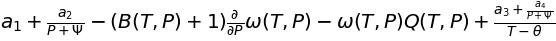

In [8]:
vtp = a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta) - omega*Q(T,P) - (B(T,P)+1)*omega.diff(P)
vtp

Note that the derivative of $ - \left[ {\left( {{B_{T,P}} + 1} \right){\omega _{T,P}} - \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}}} \right]$

In [9]:
-(1+B(T,P))*omega + (1+B(T,Pr))*(omega.subs(P,Pr))

is

In [10]:
(-(1+B(T,P))*omega + (1+B(T,Pr))*(omega.subs(P,Pr))).diff(P)

So that $\int_{{P_r}}^P {{{\bar v}^o}} dP$ may be written:

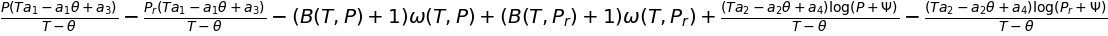

In [11]:
deltaG = sym.integrate(a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta), (P,Pr,P)) - (1+B(T,P))*omega + (1+B(T,Pr))*omega.subs(P,Pr)
deltaG

The second derivative of this volume integral gives the contribution to the heat capacity, i.e. $\frac{{{\partial ^2}G}}{{\partial {T^2}}} =  - \frac{{\partial S}}{{\partial T}} =  - \frac{{{C_P}}}{T}$ so that  

${{\bar c}_P}\left( {T,P} \right) - {{\bar c}_P}\left( {T,{P_r}} \right) =  - T\frac{{{\partial ^2}\int_{{P_r}}^P {{{\bar v}^o}} dP}}{{\partial {T^2}}}$

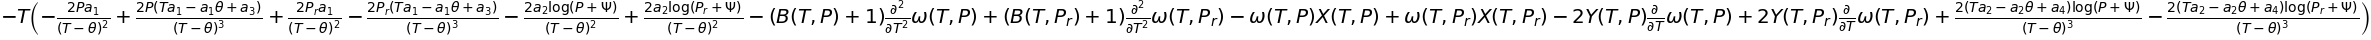

In [12]:
-T*deltaG.diff(T,2)

## Heat Capacity functions
Heat capacity is parameterized as (Tanger and Helgeson, 1988, eq A-4, p 78):

${{\bar c}_P} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} - \left[ {\frac{{2T}}{{{{\left( {T - \theta } \right)}^3}}}} \right]\left[ {{a_3}\left( {P - {P_r}} \right) + {a_4}\ln \left( {\frac{{\Psi  + P}}{{\Psi  + {P_r}}}} \right)} \right] + \omega TX + 2TY\frac{{\partial \omega }}{{\partial T}} - T\left( {\frac{1}{\varepsilon } - 1} \right)\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}$  

or equivalently, as the Born function is defined as $B =  - \frac{1}{\varepsilon }$  

${{\bar c}_P} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} - \left[ {\frac{{2T}}{{{{\left( {T - \theta } \right)}^3}}}} \right]\left[ {{a_3}\left( {P - {P_r}} \right) + {a_4}\ln \left( {\frac{{\Psi  + P}}{{\Psi  + {P_r}}}} \right)} \right] + \omega TX + 2TY\frac{{\partial \omega }}{{\partial T}} + T\left( {B + 1} \right)\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}$  

at the reference pressure this expression becomes  

${\bar c_{{P_r}}} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + {\omega _{{P_r}}}T{X_{T,{P_r}}} + 2T{Y_{T,{P_r}}}{\left. {\frac{{\partial \omega }}{{\partial T}}} \right|_{T,{P_r}}} + T\left( {{B_{T,{P_r}}} + 1} \right){\left. {\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$  

Note that the "Born" function terms are the equivalent of $T{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$, so that the reference pressure heat capacity can be equivalently written:  

${{\bar c}_{{P_r}}} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + T{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$

as demonstrated here:

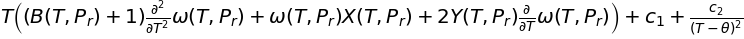

In [13]:
c1,c2 = sym.symbols('c1 c2')
ctpr = c1 + c2/(T-theta)**2 + (T*((B(T,P)+1)*omega).diff(T,2)).subs(P,Pr)
ctpr

## Gibbs free energy
The above analysis gives a way to write the Gibbs free energy using the identity $dG =  - SdT + VdP$, from which:  

${G_{T,P}} = {G_{{T_r},{P_r}}} - \int_{{T_r}}^T {{S_{T,{P_r}}}dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

The entropy term is given by  

${S_{T,{P_r}}} = {S_{{T_r},{P_r}}} + \int_{{T_r}}^T {\frac{{{{\bar c}_{T,{P_r}}}}}{T}dT}$  

Combining expressions  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\frac{{{{\bar c}_{T,{P_r}}}}}{T}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

Now, using the above expression for the reference pressure heat capacity we can write  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\frac{{\left( {{c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + T{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}} \right)}}{T}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

or  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\left[ {\frac{{{c_1}}}{T} + \frac{{{c_2}}}{{T{{\left( {T - \theta } \right)}^2}}} + {{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}} \right]dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

which expands to  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\left[ {\frac{{{c_1}}}{T} + \frac{{{c_2}}}{{T{{\left( {T - \theta } \right)}^2}}}} \right]dT} dT}  - \int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

Note that $\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}$ evaluates to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \int_{{T_r}}^T {\left[ {{{\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|}_{T,{P_r}}} - {{\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|}_{{T_r},{P_r}}}} \right]dT}$  

and further to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,P_r}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}\left( {T - {T_r}} \right)$  

and still further to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {\left. {\frac{{\partial B}}{{\partial T}}} \right|_{{T_r},{P_r}}}{\omega _{{T_r},{P_r}}}\left( {T - {T_r}} \right) - {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}\left( {T - {T_r}} \right)$  

recognizing that $Y = \frac{{\partial B}}{{\partial T}}$, we have finally  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {Y_{{T_r},{P_r}}}\left( {T - {T_r}} \right){\omega _{{T_r},{P_r}}} - {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\left( {T - {T_r}} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}$  

Note that:  

$ - \int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  =  - \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} + \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} + {Y_{{T_r},{P_r}}}\left( {T - {T_r}} \right){\omega _{{T_r},{P_r}}} + {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\left( {T - {T_r}} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}$  

and

$\int_{{P_r}}^P {{V_{T,P}}dP}  = f\left( {T,\theta ,{a_1},{a_2},{a_3},{a_4},T,P,{P_r}} \right) - \left( {{B_{T,P}} + 1} \right){\omega _{T,P}} + \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}}$

Add to the above parameters the reference state enthalpy, $H_{ref}$ and the reference state entropy, $S_{ref}$

In [14]:
Gref,Sref = sym.symbols('G_ref S_ref')

##  Derive an expression for the Gibbs free energy
**Note,** The *Shock et al. (1992)* derivation has two different equations for $G^\circ_{P,T}$, one for charged species and one for neutral. The two equations are implemented in DEW-MELTS, but not in the DEW spreadsheet. I can't see any difference between the two, and so I opt to use the single equation here. (SM Nov 2019)

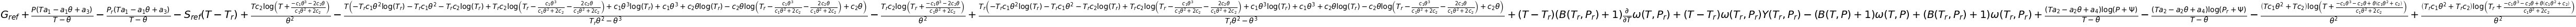

In [15]:
gtp = Gref - Sref*(T-Tr) - sym.integrate(sym.integrate((c1 + c2/(T-theta)**2)/T, (T,Tr,T)), (T,Tr,T)) \
    - (B(T,Pr)+1)*omega.subs(P,Pr) + (B(Tr,Pr)+1)*omega.subs(P,Pr).subs(T,Tr) \
    + Y(Tr,Pr)*(T-Tr)*omega.subs(P,Pr).subs(T,Tr) + (B(Tr,Pr)+1)*(T-Tr)*omega.diff(T).subs(P,Pr) \
    + sym.integrate(a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta), (P,Pr,P)) - (1+B(T,P))*omega + (1+B(T,Pr))*omega.subs(P,Pr)
gtp

At the reference pressure, $\omega$ is a constant, $\omega_0$, and its derivatives are zero too. The previous implementations prescribe the values of $Y$ and $B$ at $T_r$ and $P_r$. The values differ slightly from the direct calculation with SWIM.

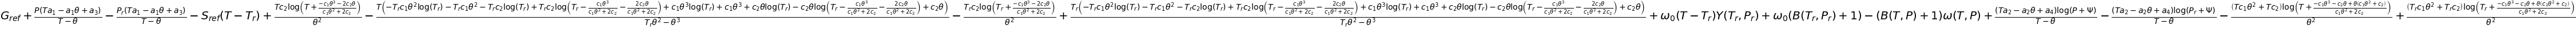

In [17]:
gtp = gtp.subs(omega.subs(T,Tr).subs(P,Pr), omega0)
gtp = gtp.subs(omega.diff(T).subs(P,Pr),0)
gtp = gtp.subs(Y(Tr,Pr),-5.79865E-05)
gtp = gtp.subs(B(Tr,Pr),-1/78.47)
gtp

Substitute the definition of the omega function into the expression for the Gibbs free energy

In [27]:
gtp = gtp.subs(omega,omega_def)
gtp

                                                                              
                                                                              
                                                                              
                                                                        T⋅c₂⋅l
                                                                              
        P⋅(T⋅a₁ - a₁⋅θ + a₃)   Pᵣ⋅(T⋅a₁ - a₁⋅θ + a₃)                          
G_ref + ──────────────────── - ───────────────────── - S_ref⋅(T - Tᵣ) + ──────
               T - θ                   T - θ                                  
                                                                              
                                                                              
                                                                              
                                                                              
                                                    

The "charge" contribution to the Gibbs free energy is 

In [19]:
gtp-gtp.subs(z,0)

                                 ⎛⎧                           ω₀              
                                 ⎜⎪                                           
                                 ⎜⎪                                    η⋅z    
                                 ⎜⎪                                    ─── + ω
                                 ⎜⎪          η⋅z                        rH    
                                 ⎜⎪- ─────────────────── + ───────────────────
ω₀⋅(B(T, P) + 1) - (B(T, P) + 1)⋅⎜⎨  rH + gSolvent(T, P)       ⎛z    ω₀⎞      
                                 ⎜⎪                            ⎜── + ──⎟⋅│z│⋅g
                                 ⎜⎪                            ⎝rH   η ⎠      
                                 ⎜⎪                        1 + ───────────────
                                 ⎜⎪                                          2
                                 ⎜⎪                                         z 
                                 ⎝⎩                 

## Predicting parameters from correlations

Define the reference volume, $v_{ref}$, and the reference heat capacity, $c_p$; terms that do not feature directly in the equation for $G_{t,p}$ as they are subsumed into the $a_n$ and $c_n$ coefficients. Define also two variables to act as switches to select the appropriate correlation coefficients.

In [20]:
v_ref = sym.symbols('v_ref')
cp_ref = sym.symbols('C_p_ref')
compl = sym.symbols('complex')
gas = sym.symbols('gas')

The value of $\omega$ predicted (from $S^0_{Pr,Tr}$) depends on the charge and type of species:

In [21]:
# omega_prd = sym.Piecewise((-1514.4*Sref + 1.62e5*z*4.184,sym.StrictLessThan(z,0)),
#                           (-1514.4*Sref + 0.544e5*z*4.184,sym.StrictGreaterThan(z,0)),
#                           (0.3e5,sym.Eq(z,0) & sym.Eq(gas,0)),
#                           (-0.3e5,True))
omega_prd = sym.Piecewise((-1514.4*Sref + 2.1764e5*4.184,sym.Eq(z,4)),
                          (-1514.4*Sref + 1.5793e5*4.184,sym.Eq(z,3)),
                          (-1514.4*Sref + 1.0579e5*4.184,sym.Eq(z,2)),
                          (-1514.4*Sref + 0.5517e5*4.184,sym.Eq(z,1)),
                          (-1514.4*Sref + 1.6291e5*4.184,sym.Eq(z,-1)),
                          (-1514.4*Sref + 3.2127e5*4.184,sym.Eq(z,-2)),
                          (-1514.4*Sref + 4.8115e5*4.184,sym.Eq(z,-3)),
                          (-1514.4*Sref + 6.4860e5*4.184,sym.Eq(z,-4)),
                          (0.3e5*4.184,sym.Eq(z,0) & sym.Eq(gas,0)),
                          (-0.3e5*4.184,True))
omega_prd

⎧910605.76 - 1514.4⋅S_ref        for z = 4     
⎪                                              
⎪660779.12 - 1514.4⋅S_ref        for z = 3     
⎪                                              
⎪442625.36 - 1514.4⋅S_ref        for z = 2     
⎪                                              
⎪230831.28 - 1514.4⋅S_ref        for z = 1     
⎪                                              
⎪681615.44 - 1514.4⋅S_ref       for z = -1     
⎨                                              
⎪1344193.68 - 1514.4⋅S_ref      for z = -2     
⎪                                              
⎪2013131.6 - 1514.4⋅S_ref       for z = -3     
⎪                                              
⎪2713742.4 - 1514.4⋅S_ref       for z = -4     
⎪                                              
⎪        125520.0           for gas = 0 ∧ z = 0
⎪                                              
⎩        -125520.0               otherwise     

By differentiating the definition of the born solvation coefficient:

$\Delta G^0 = \omega*\left(\frac{1}{\epsilon_{H_2O} -1}\right)$

assuming $\omega$ is constant with $T$ and $P$, the solvation volume may be calculated:

$\Delta V^0_s = -\omega Q_{P,T}$.

This in turn may be related to the non-solvation volume:

$V^0 = \Delta V^0_s + \Delta V^0_n$

at the reference pressure and temperature:

$\Delta V^0_{n,P_r,T_r} = V^0_{P_r,T_r} - \omega_{P_r,T_r} Q_{P_r,T_r}$

In [22]:
dVn = (v_ref + omega0*0.05903e-5)

The $a_n$ parameters of the EOS may then be estimated using their observed correlations with $\Delta V^0_{n,P_r,T_r}$:

In [23]:
a1_prd = sym.Piecewise(((0.19421*dVn + 0.15204)*4.184,sym.Eq(z,0) | sym.Eq(compl,1)),
                       (((0.1304*sym.Abs(z)-0.0217)*dVn +0.14567*sym.Abs(z)\
                         + 0.06187)*4.184, True))
sigma_prd = 1.11 * dVn +0.18
a2_prd = (sigma_prd - a1_prd)*(Pr+Psi)
a4_prd = (-4.134*a2_prd - 27790*4.184)
a3_prd = ((dVn - a1_prd - a2_prd/(Psi + Pr))*(Tr-theta) - (a4_prd/(Psi+Pr)))
a1_prd

⎧              4.79662809992e-7⋅ω₀ + 0.81257464⋅v_ref + 0.63613536            
⎨                                                                             
⎩4.184⋅(5.903e-7⋅ω₀ + v_ref)⋅(0.1304⋅│z│ - 0.0217) + 0.60948328⋅│z│ + 0.258864

    for complex = 1 ∨ z = 0
                           
08         otherwise       

The $c_n$ parameters for the heat capacity are estimated from $\omega_{P_r,T_r}$ and $C_{p,ref}$:

In [24]:
c2_prd = 1e4*(0.2037*cp_ref - 3.0346*4.184)
c1_prd = cp_ref - c2_prd/(Tr-theta)**2 + 298.15*0.0309e-5*omega0

Substitute the predicted parameters into the free energy expression. To control whether the predicted parameters are used in preference to explicitly stated parameters, two new switch variables are introduced. This will replace $a_1$, $a_2$, $a_3$, $a_4$, $c_1$, and $c_2$ with $V_{P_rT_r}$ and $C_{pT_rP_r}$.

In [25]:
prd_omega = sym.symbols('prd_omega')
prd_ac = sym.symbols('prd_ac')

gtp_prd = gtp.subs({a1:sym.Piecewise((a1_prd,sym.Eq(prd_ac,1)),(a1,True)),
                    a2:sym.Piecewise((a2_prd,sym.Eq(prd_ac,1)),(a2,True)),
                    a3:sym.Piecewise((a3_prd,sym.Eq(prd_ac,1)),(a3,True)),
                    a4:sym.Piecewise((a4_prd,sym.Eq(prd_ac,1)),(a4,True)),
                    c1:sym.Piecewise((c1_prd,sym.Eq(prd_ac,1)),(c1,True)),
                    c2:sym.Piecewise((c2_prd,sym.Eq(prd_ac,1)),(c2,True))})
gtp_prd = gtp_prd.subs({omega0:sym.Piecewise((omega_prd,sym.Eq(prd_omega,1)),(omega0,True))})


Add the derived expression for *G(T,P)* and its parameter list to the model

In [26]:
params = [('G_ref','J/mole',Gref), ('S_ref','J/mole/K',Sref), 
          ('v_ref','J/bar/mole',v_ref), ('C_p_ref','J/mole/K',cp_ref),
          ('Psi', 'bar', Psi), ('eta', 'Å-J/mole', eta), ('rH', 'Å', rH),
          ('theta','K',theta), ('z', '', z), 
          ('complex','',compl), ('gas','',gas),
          ('prd_ac','',prd_ac), ('prd_omega','',prd_omega),
          ('a1','J/mole/bar',a1),('a2','J/mole',a2),('a3','J-K/mol/bar',a3),('a4','J-K/mol',a4),
          ('c1','J/mole/K',c1),('c2','J-K/mole',c2),('omega0','J/mole',omega0)
          ]
model.add_expression_to_model(gtp_prd, params)
model.set_include_born_code(True)